In [237]:
using RigidBodySim
using RigidBodyDynamics

using RigidBodyDynamics.Contact

contactmodel = SoftContactModel(hunt_crossley_hertz(k = 500e3), ViscoelasticCoulombModel(0.8, 20e3, 100.))



using RigidBodySim

using MechanismGeometries

# # @__NAME__

# PREAMBLE

# PKG_SETUP

# ## Setup

# In addition to `RigidBodyDynamics`, we'll be using the `StaticArrays` package, used throughout `RigidBodyDynamics`, which provides stack-allocated, fixed-size arrays:

using RigidBodyDynamics
using LinearAlgebra
using StaticArrays

function rod_origin_end(length, mass, name)
    frame=CartesianFrame3D(name)
    I_1 = 1 / 3. * mass * length^2   
    c_1 = .5 * length
    inertia1 = SpatialInertia(frame,
        moment=moment=I_1 * SDiagonal(1, 1, 1. / 20^2),
        com=SVector(0, 0, c_1),
        mass=mass)
    
    return RigidBody(inertia1)
end

function arm(short_length, long_length, mass, name)
    frame=CartesianFrame3D(name)
       
    c_1 = .5(short_length - long_length)
    I_1 = 1 / 12. * mass * (short_length + long_length)^2 + c_1 ^2 * mass
    
    inertia1 = SpatialInertia(frame,
        moment=moment=I_1 * SDiagonal(1, 1, 1. / 20^2),
        com=SVector(0, 0, c_1),
        mass=mass)
    
    return RigidBody(inertia1)
end

function offset_ball(distance, radius, mass, name)
    frame=CartesianFrame3D(name)
    I_1 =   mass * distance^2   
    I_ball = 2. /5 * mass * (radius)^2
    c_1 = distance
    inertia1 = SpatialInertia(frame,
        moment=moment=SDiagonal(I_1 + I_ball, I_1 + I_ball, I_ball),
        com=SVector(0, 0, c_1),
        mass=mass)
    
    return RigidBody(inertia1)
end
    

function trebuchet_range(arm_length, cw_arm_length, sling_length_1, sling_length_2, flying_weight_mass, do_gui=true)
    g = -.981 # gravitational acceleration in z-direction
    world = RigidBody{Float64}("world")
    doublependulum = Mechanism(world; gravity = SVector(0, 0, g))

    upperlink = arm(cw_arm_length, arm_length, 40 * arm_length / sqrt(2), "upper_link")


    # and a new revolute joint called 'shoulder':
    axis = SVector(1.0, 0, 0)
    shoulder = Joint("shoulder", Revolute(axis))


    # Creating a `Joint` automatically constructs two new `CartesianFrame3D` objects: a frame directly before the joint, and one directly after. To attach the new body to the world by this joint, we'll have to specify where the frame before the joint is located on the parent body (here, the world):

    before_shoulder_to_world = one(Transform3D,
        frame_before(shoulder), default_frame(world))


    # Now we can attach the upper link to the world:

    attach!(doublependulum, world, upperlink, shoulder,
        joint_pose = before_shoulder_to_world)



    lowerlink = offset_ball(1 - cw_arm_length, .05, 400, "lower_link")
    elbow = Joint("elbow", Revolute(axis))
    before_elbow_to_after_shoulder = Transform3D(
        frame_before(elbow), frame_after(shoulder), SVector(0, 0, cw_arm_length))
    attach!(doublependulum, upperlink, lowerlink, elbow,
        joint_pose = before_elbow_to_after_shoulder)
    
    flying_weight = offset_ball(sling_length_1, .05, flying_weight_mass, "flying_weight")
    
    arm_tip = Joint("arm_tip", Revolute(axis))
    before_tip_to_after_shoulder = Transform3D(
        frame_before(arm_tip), frame_after(shoulder), SVector(0, 0, -arm_length))
    attach!(doublependulum, upperlink, flying_weight, arm_tip,
        joint_pose = before_tip_to_after_shoulder)
    
    
    
    projectile = offset_ball(sling_length_2, .05, 1, "projectile")

    pin = Joint("pin", Revolute(axis))
    before_pin_to_after_fweight = Transform3D(
        frame_before(pin), frame_after(arm_tip), SVector(0, 0, sling_length_1))
    attach!(doublependulum, flying_weight, projectile, pin,
        joint_pose = before_pin_to_after_fweight)

    add_contact_point!(projectile, ContactPoint(center_of_mass(spatial_inertia(projectile)), contactmodel))
    add_contact_point!(flying_weight, ContactPoint(center_of_mass(spatial_inertia(flying_weight)), contactmodel))
    
    
    ground = HalfSpace3D(Point3D(root_frame(doublependulum), 0., 0., -1.01), FreeVector3D(root_frame(doublependulum), 0., 0., 1.))
    add_environment_primitive!(doublependulum, ground)

    state = MechanismState(doublependulum)


    # Let's first set the configurations and velocities of the joints:

    set_configuration!(state, shoulder, acos(1 / arm_length))
    set_configuration!(state, elbow, pi - acos(1 / arm_length))

    set_configuration!(state, arm_tip,  pi / 2 - acos(1 / arm_length))
    
    set_configuration!(state, pin,  0)

    set_velocity!(state, shoulder, 0)
    set_velocity!(state, elbow, 0)


    setdirty!(state)



    open_loop_dynamics = Dynamics(doublependulum);
    
    problem = ODEProblem(open_loop_dynamics, state, (0., 4))
    
    if(do_gui)
        gui = GUI(doublependulum, Skeleton())
        if !haskey(ENV, "CI") # don't try to open a GUI on a headless CI build
            open(gui)
        end
        vis = gui.visualizer # a MeshCatMechanisms.MechanismVisualizer
        set_configuration!(vis, configuration(state));
        gui_callback = CallbackSet(gui);
        rate_limiter = RealtimeRateLimiter(max_rate = 1)
        callbacks = CallbackSet(gui_callback, rate_limiter) # this is how you combine callbacks
        res = solve(problem, Tsit5(), abs_tol = 1e-10, dt = 0.005, callback = callbacks);

    else
        res = solve(problem, Tsit5(), abs_tol = 1e-10, dt = 0.005);
    end
    
    #print(length(res), " ")
    
    range = 0
    rs = []
    for t in 0:.05:4
        u = res(t)
        set_configuration!(state, u[1:4])
        set_velocity!(state, u[5:8])
        r = transform_to_root(state, projectile) * center_of_mass(spatial_inertia(projectile))
        push!(rs, [r.v[2], r.v[3]])
        v = point_velocity(
            twist_wrt_world(state, projectile), 
            r
        )
        
        #println(v)
        if(u[3] > 2 * pi || u[3] < -2 * pi)
            break
        end
        if(u[4] > 2 * pi || u[4] < -2 * pi)
            break
        end
        range = max(-v.v[2] * v.v[3] * 2 / g, range)
        
    end
    return range
end

trebuchet_range (generic function with 4 methods)

In [238]:
res = trebuchet_range(sqrt(2), .35, sqrt(2), sqrt(2), 10, true)

130.60707333812093

In [239]:
using BlackBoxOptim

In [294]:
xs = []
scores = []
best = bboptimize(;SearchRange = [(1., 5.), (0.05, .9), (0.1, 5.), (0.1, 5.), (.1, 15.)], MaxTime=20,
    TraceMode=:adaptive_de_rand_1_bin, Logging=:verbose) do x
    push!(xs, copy(x))
    score = -trebuchet_range(x[1], x[2], x[3], x[4], x[5], false)
    push!(scores, score)
    score
end

t = best_candidate(best)
trebuchet_range(t[1], t[2], t[3], t[4], t[5], true)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
0.50 secs, 111 evals, 65 steps, improv/step: 0.477 (last = 0.4769), fitness=-184.569240831
DE modify state:
1.00 secs, 254 evals, 172 steps, improv/step: 0.442 (last = 0.4206), fitness=-341.618169670
DE modify state:
1.51 secs, 406 evals, 310 steps, improv/step: 0.387 (last = 0.3188), fitness=-358.161910901
DE modify state:
2.01 secs, 572 evals, 468 steps, improv/step: 0.368 (last = 0.3291), fitness=-454.793976199
DE modify state:
2.51 secs, 756 evals, 649 steps, improv/step: 0.345 (last = 0.2873), fitness=-461.681478639
DE modify state:
3.01 secs, 939 evals, 831 steps, improv/step: 0.330 (last = 0.2747), fitness=-482.024334146
DE modify state:
3.51 secs, 1131 evals, 1023 steps, improv/step: 0.307 (last = 0.2083), fitness=-482.024334146
DE modify state:
4.02 secs, 1316 ev

521.1075845969442

In [267]:
trebuchet_range(t[1] + .01, t[2], t[3], t[4], t[5], true)

518.2347779658514

In [268]:
r = hcat(rs...)
using PyPlot
plot(r[1, :], r[2, :])


UndefVarError: UndefVarError: rs not defined

In [258]:
using Profile
@profile (for i = 1:100; trebuchet_range(t[1], t[2], t[3], t[4], t[5], false); end)

In [259]:
Profile.print()
Profile.clear()

110 .\task.jl:259; (::getfield(IJulia, Symbol("##15#1...
 1   ...gI2uA\src\eventloop.jl:5; eventloop(::ZMQ.Socket)
  1 ...Julia\gI2uA\src\msg.jl:69; recv_ipython(::ZMQ.Socket)
   1 ...ZMQ\ABGOx\src\comm.jl:106; recv(::ZMQ.Socket, ::Type{String})
    1 ...ZMQ\ABGOx\src\comm.jl:75; _recv!(::ZMQ.Socket, ::Base.RefVal...
     1 ...Q\ABGOx\src\socket.jl:44; wait
      1 ...Q\ABGOx\src\socket.jl:0; #wait
       1 ...\src\FileWatching.jl:460; #wait#1(::Bool, ::Bool, ::Funct...
        1 .\stream.jl:47; stream_wait(::FileWatching._FDW...
         1 .\event.jl:46; wait(::Condition)
          1 .\event.jl:246; wait()
           1 .\libuv.jl:98; process_events
 109 ...gI2uA\src\eventloop.jl:8; eventloop(::ZMQ.Socket)
  109 .\essentials.jl:741; invokelatest
   109 .\essentials.jl:742; #invokelatest#1
    109 ...rc\execute_request.jl:67; execute_request(::ZMQ.Socket, ::I...
     109 ...c\SoftGlobalScope.jl:218; softscope_include_string(::Modu...
      109 .\boot.jl:328; eval
       109 .\In[258]:2;

                       2 ...algorithms.jl:274; mass_matrix!
                        1 ...algorithms.jl:260; mass_matrix!(::Symmet...
                         1 ...nteraction.jl:229; *
                          1 ...atial\util.jl:24; colwise
                           1 ...tial\util.jl:32; _colwise
                            1 .\tuple.jl:159; ntuple
                             1 ...ial\util.jl:32; #5
                              1 ...c\linalg.jl:202; cross
                               1 ...\linalg.jl:208; _cross
                                1 .\float.jl:399; *
                        1 ...algorithms.jl:263; mass_matrix!(::Symmet...
                      2 ..._algorithms.jl:862; #dynamics!#114(::Rigid...
                       1 ...algorithms.jl:762; dynamics_solve!(::Dyna...
                        1 .\broadcast.jl:756; materialize!
                         1 .\broadcast.jl:258; instantiate
                          1 ...ffeqfastbc.jl:19; check_broadcast_axes
                   

                         1 ...nism_state.jl:776; _update_twists_wrt_wo...
                          1 ...ialmotion.jl:220; transform
                           1 ...tial\util.jl:103; transform_spatial_m...
                            1 ..._multiply.jl:8; *
                             1 ...multiply.jl:45; _mul
                              1 .\float.jl:395; macro expansion
                       1 ...algorithms.jl:698; contact_dynamics!(::Dy...
                        1 ...reevectors.jl:68; *
                         1 ...x_multiply.jl:8; *
                          1 ...x_multiply.jl:45; _mul
                           1 ..._multiply.jl:58; macro expansion
                            1 .\float.jl:395; +
                       4 ...algorithms.jl:711; contact_dynamics!(::Dy...
                        4 ...rc\contact.jl:108; contact_dynamics!(::S...
                         4 ...rc\contact.jl:142; normal_force
                          3 .\math.jl:780; ^
                          1 .\mat

                  1 .\sort.jl:0; searchsortedfirst
              1 ...\generic_dense.jl:260; ode_interpolation(::Float64...
              3 ...\generic_dense.jl:269; ode_interpolation(::Float64...
               1 ...\generic_dense.jl:363; ode_interpolant(::Float64, ...
                1 .\boot.jl:402; similar
               1 ...\generic_dense.jl:367; ode_interpolant(::Float64, ...
                1 ...\interpolants.jl:280; _ode_interpolant!(::Array{...
                 1 ...\diffeqfastbc.jl:79; macro expansion
                  1 .\broadcast.jl:756; materialize!
                   1 .\broadcast.jl:258; instantiate
                    1 .\broadcast.jl:463; check_broadcast_axes
                     1 .\broadcast.jl:462; check_broadcast_axes
                      1 ...iffeqfastbc.jl:19; check_broadcast_axes
                       1 .\broadcast.jl:206; axes
                        1 .\broadcast.jl:208; _axes
                         1 .\broadcast.jl:421; combine_axes
                    

In [66]:
import AtlasRobot

mechanism = AtlasRobot.mechanism(add_flat_ground=true)

state = MechanismState(mechanism)


# Let's first set the configurations and velocities of the joints:
AtlasRobot.setnominal!(state)
setdirty!(state)



using RigidBodySim

using MechanismGeometries
open_loop_dynamics = Dynamics(mechanism);

gui = GUI(mechanism, Skeleton())
if !haskey(ENV, "CI") # don't try to open a GUI on a headless CI build
    open(gui)
end
vis = gui.visualizer # a MeshCatMechanisms.MechanismVisualizer
set_configuration!(vis, configuration(state));
gui_callback = CallbackSet(gui);
problem = ODEProblem(open_loop_dynamics, state, (0., 5.))
rate_limiter = RealtimeRateLimiter(max_rate = 1.)
callbacks = CallbackSet(gui_callback, rate_limiter) # this is how you combine callbacks
solve(problem, Tsit5(), abs_tol = 1e-10, dt = 0.05, callback = callbacks);

In [1]:
3

3

In [58]:
Pkg.add("AtlasRobot")

 Resolving package versions...
 Installed AtlasRobot ─ v0.4.0
  Updating `C:\Users\hasti\.julia\environments\v1.1\Project.toml`
  [436ed74b] + AtlasRobot v0.4.0
  Updating `C:\Users\hasti\.julia\environments\v1.1\Manifest.toml`
  [436ed74b] + AtlasRobot v0.4.0
  Building AtlasRobot → `C:\Users\hasti\.julia\packages\AtlasRobot\iQG8w\deps\build.log`


In [270]:
using PyPlot

┌ Info: Recompiling stale cache file C:\Users\hasti\.julia\compiled\v1.1\PyPlot\oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


In [295]:
xa = hcat(xs...)

5×6756 Array{Float64,2}:
 2.61793   1.18453   1.18453    1.72247  …   1.3724     1.36809    1.37234
 0.590162  0.147985  0.185786   0.88413      0.651903   0.635028   0.66089
 4.52511   3.54528   3.54528    1.0638       1.39192    1.4024     1.37971
 0.755879  2.9912    2.9912     1.3414       2.59538    2.62047    2.58022
 7.01747   9.2816    9.2816    12.404       10.5589    10.6055    10.5611 

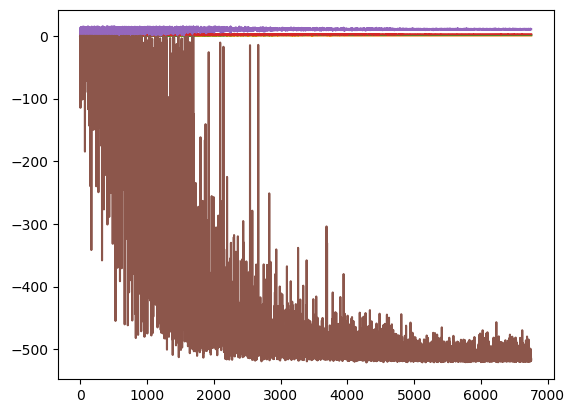

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000015974DEB8>

In [302]:
PyPlot.plot(xa[:, 1:end]')



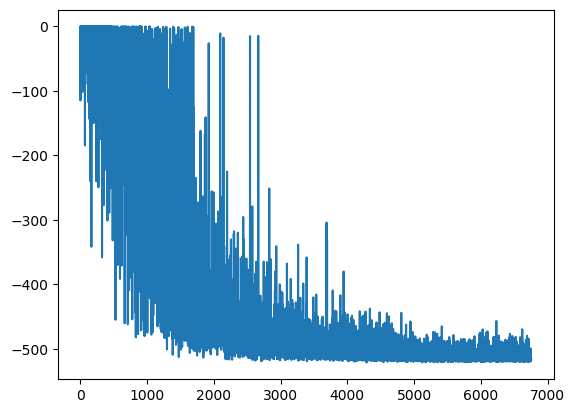

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000014A53A128>

In [303]:
PyPlot.plot(scores)

In [304]:
a = [1, 2]

2-element Array{Int64,1}:
 1
 2

In [312]:
a'.* a

2×2 Array{Int64,2}:
 1  2
 2  4

In [314]:
"l"

"l"